In [1]:
import numpy as np
import math
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Part I
### Forward Simulation and Logistic Regression

**FORWARD SIMULATION**

In [2]:
alpha=0.9 # Probability parameter alpha in (0.5, 1) for P(Z|C)
beta=0.2  # Transition probability parameter for moving to and from parallel processing
gamma=0.1  # Transition probability parameter between states
lmda=(1, 5)  # Rate parameters for the Poisson distribution modeling spike counts under each attention state.

# Transition probability matrix for the HMM, parameterized by gamma and beta (Transition probabilities of switching between states C in {0, 1, 2}).
Gamma = np.array([[1-gamma, 0, gamma], [0, 1-gamma, gamma], [beta*0.5, beta*0.5, 1-beta]])
Z_prob = [[alpha, 1-alpha], [1-alpha, alpha], [0.5, 0.5]]

def forward_sim(n, T, alpha=0.9, gamma=0.1, beta=0.2, lmda=(1, 5)): 
    # Pre-defined (transition) probabilities
    Gamma = [[1-gamma, 0, gamma], [0, 1-gamma, gamma], [beta*0.5, beta*0.5, 1-beta]]
    

    # Initialize arrays
    C = np.zeros(T, dtype=int)
    Z = np.zeros((T, n), dtype=int)
    X = np.zeros((T, n), dtype=int)

    # Initial state
    C[0] = 2

    # Initialize X and Z for t=0
    for i in range(0, n):
            Z[0, i] = random.choices([0, 1], Z_prob[C[0]])[0]
            X[0, i] = np.random.poisson(lam = lmda[Z[0, i]])

    # Simulate the proces for the remaining t=1 to t=T timesteps
    for t in range(1, T):
        C[t] = random.choices([0, 1, 2], Gamma[C[t-1]])[0]
        for i in range(0, n):
            Z[t, i] = random.choices([0, 1], Z_prob[C[t]])[0]
            X[t, i] = np.random.poisson(lam = lmda[Z[t, i]])

    return C, Z, X

**VISUALIZATION**

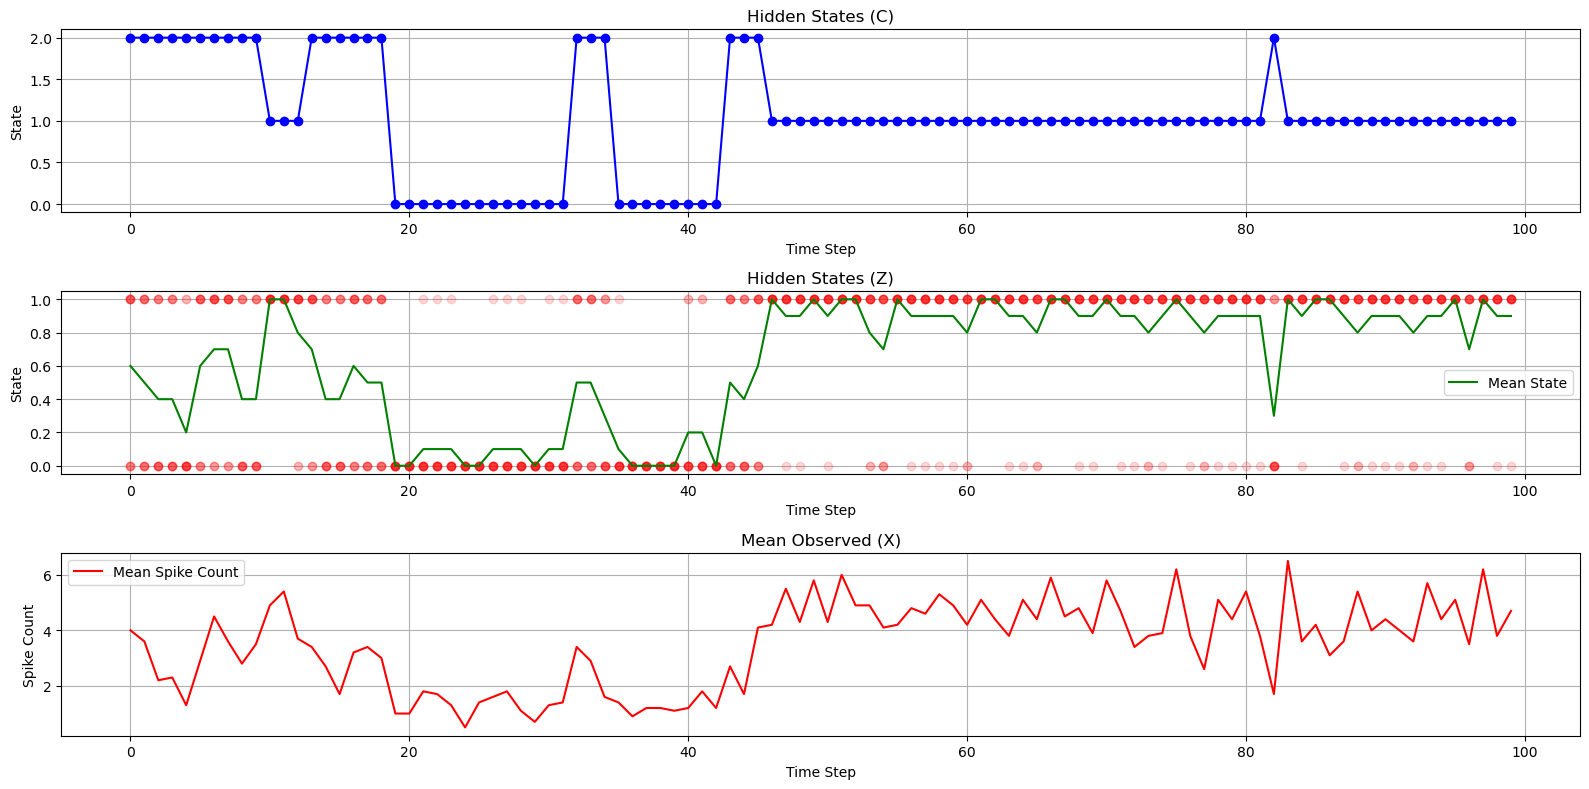

In [3]:
T = 100  # Time period
n = 10   # Number of neurons

C, Z, X = forward_sim(n, T)

#mean Z pr tid
avg_Z = np.mean(Z,axis=1).reshape(1,-1)[0]
avg_X = np.mean(X,axis=1).reshape(1,-1)[0]

# Visualize the data
plt.figure(figsize=(16, 8))

# Plot hidden states (C)
plt.subplot(3, 1, 1)
plt.plot(range(T), C, marker='o', color='blue')
plt.title('Hidden States (C)')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.grid(True)

# Plot observed states (Z)
plt.subplot(3, 1, 2)
for i in range(n):
    plt.plot(range(T), Z[:, i], marker='o', alpha=1.5/n, color = 'red', linewidth = 0)
plt.plot(range(T), avg_Z, color='green', label = 'Mean State')
plt.title('Hidden States (Z)')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.legend()
plt.grid(True)

# Plot observed states (X)
plt.subplot(3, 1, 3)
plt.plot(range(T), avg_X, color='red', label = 'Mean Spike Count')
plt.title('Mean Observed (X)')
plt.xlabel('Time Step')
plt.ylabel('Spike Count')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### MULTICLASS LOGISTIC REGRESSION 

In [4]:
# Split the date for validation
X_train, X_test, C_train, C_test = train_test_split(X, C, test_size=0.2, random_state=42)

# Assert shapes
assert(X_train.shape == (T-0.2*T, n))
assert(X_test.shape == (0.2*T, n))
assert(C_train.shape == (T-0.2*T, ))
assert(C_test.shape == (0.2*T, ))

In [5]:
# Train multinomial logistic regression using Scikit-Learn
LogReg = LogisticRegression(random_state=42, multi_class='multinomial', max_iter=200)

LogReg.fit(X_train, C_train)
LogReg.score(X_test, C_test)

0.7

In [6]:
# Predict_proba essentially returns the CPD for P(C|X)
LogReg.predict_proba(X)

array([[5.89034352e-03, 5.97198494e-01, 3.96911162e-01],
       [1.25563631e-05, 1.63496249e-01, 8.36491195e-01],
       [5.92009547e-02, 2.37079270e-03, 9.38428253e-01],
       [1.52697866e-01, 3.81770234e-03, 8.43484432e-01],
       [9.98620601e-01, 1.35724004e-07, 1.37926355e-03],
       [1.20474390e-02, 4.15911476e-01, 5.72041085e-01],
       [6.30592654e-05, 5.98448983e-01, 4.01487958e-01],
       [1.38420566e-02, 2.75064623e-01, 7.11093320e-01],
       [8.45416844e-05, 6.03339560e-01, 3.96575898e-01],
       [9.51543066e-04, 1.62390557e-01, 8.36657900e-01],
       [2.78070736e-09, 9.91387416e-01, 8.61258097e-03],
       [2.71218869e-11, 9.98956323e-01, 1.04367682e-03],
       [1.23311958e-07, 7.73914506e-01, 2.26085371e-01],
       [2.60016335e-02, 2.34382945e-02, 9.50560072e-01],
       [2.47744061e-05, 2.22262665e-01, 7.77712561e-01],
       [1.53266794e-01, 6.45233403e-04, 8.46087973e-01],
       [7.69751851e-05, 7.47577747e-02, 9.25165250e-01],
       [8.87362568e-04, 1.72325

# Part II
### Inference algorithms, Testing Inference on Simulated Data

**INFERENCE OF Z**

In [7]:
def PX_given_Z(x, z, lmda=(1, 5)):   # Returns answer to the query P(X|Z)
    return (np.exp(-1 * lmda[z]) * ((lmda[z]**x)/math.factorial(x)))

In [8]:
T = 100  # Time period
n = 10   # Number of neurons


C, Z, X = forward_sim(n, T)

In [9]:
#We assume that P(Z=0) = 0.5 due to the distribution of Z | C, and due to an assumption that P(C=1) = P(C=0)
Z_marg = (0.5, 0.5)


#We start by calculating P(X) for every observed X and save them in a table. It doesn't make sense to compute P(X) for unobserved values of X
X_marg = np.zeros(np.max(X)+1)
#We calculate P(X) using the formula: P(X=x) = P(X=x|Z=0)P(Z=0) + P(X=x|Z=1)P(Z=1)
#This works because Z ony takes values in {0,1}. We simply obtain the joint distribution P(X,Z) and sum out Z
for i in range(len(X_marg)):
    X_marg[i] = PX_given_Z(i, 0)*Z_marg[0] + PX_given_Z(i, 1)*Z_marg[1]


#X_marg[i] holds the answer for the query P(X=i)
#Likewise Z_marg[i] holds the answer for the query p(Z=i)
    

In [10]:
Z_inferred = np.zeros((T,n,2), dtype=float) 
#For every observed X=x, we calculate the conditional probaility P(Z=0|X=x)
#We use Bayes theorem to do this. 

for i in range(Z_inferred.shape[0]): 
    for j in range(Z_inferred.shape[1]): 
        Z_inferred[i,j,0] = (PX_given_Z(X[i,j], 0)*Z_marg[0])/(X_marg[X[i,j]])
        Z_inferred[i,j,1] = 1 - Z_inferred[i,j,0] 


In [11]:
def PZ_given_C(c, z, alpha=0.9):
    Z_prob = np.array([[alpha, 1-alpha], [1-alpha, alpha], [0.5, 0.5]])
    return Z_prob[c, z]

### Forward Algorithm

In [12]:
def calc_emission_proba(t: int, c: int) -> float:
    """
    Calculates the emission probabilities at timestep t
    The probabilities given by P(X_1,t...X_n,t|C_t)
    P(Z|C) by function PZ_given_C(c, z)
    P(X|Z) Poisson distribution given by PX_given_Z(x, z)
    """
    emission_proba = 0.
    for i in range(n):
        emission_proba += np.log(PZ_given_C(c, 0)*PX_given_Z(X[t, i], 0) + PZ_given_C(c, 1)*PX_given_Z(X[t, i], 1))
    emission_proba = np.exp(emission_proba)
    return emission_proba

In [13]:
def forward():
    """
    Iteratively updates the Alpha_t vectors in the Alpha matrix.
    The Alpha matrix represents the P(C|X) distribution for each timestep T as an T x 3 matrix.
    """
    # Initialization of the forward probabilities matrix, Alpha.
    Alpha = np.zeros((T, 3), dtype=float)  # T x 3 matrix P(C|X)
    Alpha[0, 2] = 1.  # Assumed state C_0=2 becomes our Alpha_0 vector (Alpha_0=[0, 0, 1])
    for t in range(1, T):
        for c in range(3):
            c_prev = 0. # For calculating SUM_c_t-1 P(C_t|c_t-1)*Alpha_t-1(c_t-1)
            for c_ in range(3):
                c_prev += Gamma[c_, c]*Alpha[t-1, c_]
            Alpha[t, c] = calc_emission_proba(t, c)*c_prev # Alpha_t = P(X_1,t,...,X_n,t|C_t) * SUM_c_t-1 P(C_t|c_t-1)*Alpha_t-1(c_t-1)
        row_sum = np.sum(Alpha[t], axis=0) # Normalizing sum for each row
        Alpha[t] = Alpha[t]/row_sum # Row-wise normalization for the CPD, normalizing the unnormalized Gibbs measure of each row.
    return Alpha

**CONFIDENCE AGAINST SIMULATED DATA**

In [14]:
C_inferred = forward() 
def calc_confidence_of_C(infered_C, true_C):
    Confidence = np.zeros(len(true_C), dtype = float)
    for c in true_C: 
        for t in range(0, len(true_C)): 
            Confidence[t] = infered_C[t, true_C[t]]
    return np.average(Confidence)

In [15]:
def calc_confidence_of_Z(inferred_Z, true_Z):
    Confidence = np.zeros((true_Z.shape[0],true_Z.shape[1]), dtype = float)
    for t in range(0,true_Z.shape[0]): 
        for n in range(0, true_Z.shape[1]): 
            Confidence[t,n] = inferred_Z[t,n,[true_Z[t,n]]]
    return np.average(Confidence)


**VISUALIZING CONFIDENCE**

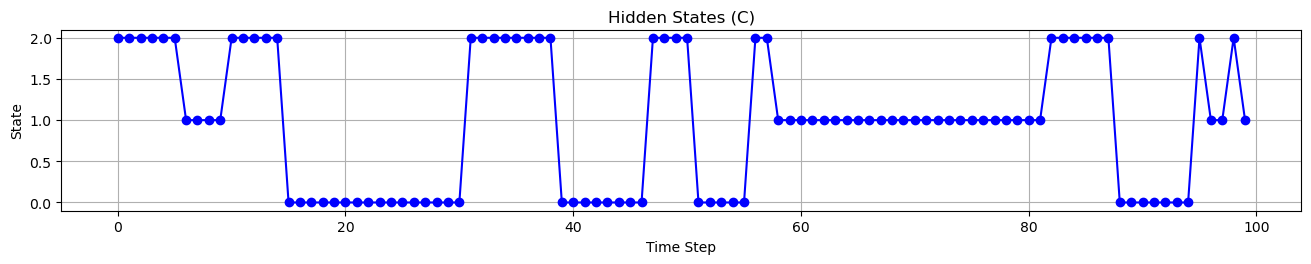

In [16]:
plt.figure(figsize=(16, 8))

# Plot hidden states (C)
plt.subplot(3, 1, 1)
plt.plot(range(T), C, marker='o', color='blue')
plt.title('Hidden States (C)')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.grid(True)

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns

In [18]:
C_pred = np.array([C_inferred[i].argmax() for i in range(len(C_inferred))])

In [19]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(C, C_pred)

In [20]:
cm_df = pd.DataFrame(cm,
                     index = ['2','1','0'], 
                     columns = ['2','1','0'])

### Precision, recall, f1-score, and support
* The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives.
    * The precision is intuitively the ability of the classifier not to label a negative sample as positive.

* The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives.
    * The recall is intuitively the ability of the classifier to find all the positive samples.

* The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

* The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

* The support is the number of occurrences of each class in y_true.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

In [21]:
report = classification_report(C,C_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.69      0.81        36
           1       0.92      0.77      0.84        31
           2       0.62      0.91      0.74        33

    accuracy                           0.79       100
   macro avg       0.84      0.79      0.80       100
weighted avg       0.84      0.79      0.80       100



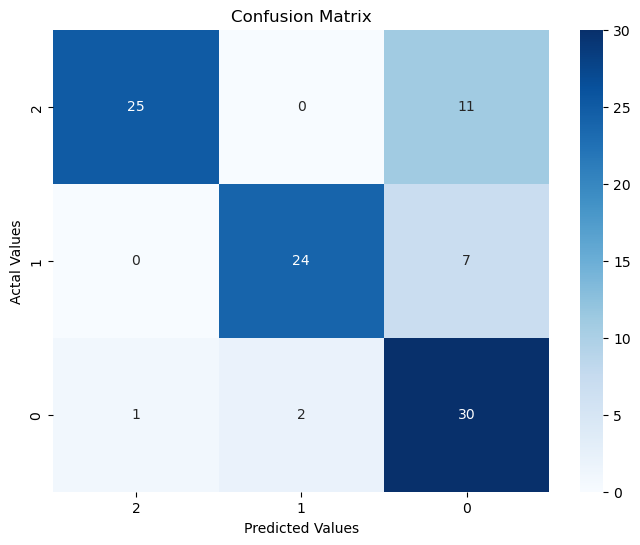

In [26]:
#Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()